# Project: Investigating the Medical Appointment Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The medical appointment dataset contains information on over 100k appointments from the country of Brazil. The dataset was originally sourced from [Kaggle][1]. It was created to study what factors were useful in predicting if patients would miss thier appointments. It contains basic demographic information on the patients as well as whether or not the patient received SMS notifications. In addition, it indicates if the patient received financial aid.

### Research questions:
 - Is age indicative of whether a patient will make their appointments?
 - Do SMS notifications coincide with fewer no shows?
 - Do some days of the week have more no shows than others?
 
[1]: https://www.kaggle.com/joniarroba/noshowappointments

In [1]:
# import modules for working with data
import pandas as pd
import numpy as np

# import stats functions from scipy
from scipy import stats

# imports for better control of output and plots
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# show plots in the notebook
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties
The Pandas library will be used to work with the data. The following commands will low that dataset into a pandas dataframe and display basic information about it.

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The ouput shows that there are 110,527 entries described by 14 fields. There are also no null fields. The following command will display the first five rows to allow for a closer look

In [3]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Each row contains a patient id and an appointment id, but it is not clear if either of those fields are unique to each entry. Based on the dataset it should be expected that each AppointmentID is unique, while PatientIds could appear more than once. Pandas's `nunique()` method can be used to verify this assumption.

In [4]:
# count the number of unique patient and appointment IDs
df.loc[:, ['PatientId', 'AppointmentID']].nunique()

PatientId         62299
AppointmentID    110527
dtype: int64

The results confirm that there are as many unique AppointmentIDs as there are rows. There are also less PatientIds than records, confirming that at least some values are reused.
Because the AppointmentIDs are unique to each row it will be set as the dataframe index.

In [5]:
# This command resets the index. The 'verify_integrity' parameter serves as on last check to make sure
# there are no duplicate values.
df.set_index('AppointmentID', inplace=True ,verify_integrity=True)

Of the numeric fields Scholarship, Hipertension, Diabetes, Alcoholism, Handicap and SMS_received appear to be binary fields. The `describe` method from Pandas returns information that can be used to verify.

In [6]:
df.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


All of fields except for Handcap range between 0 and 1, which has a maximum value of 4. A [forum discussion][1] on Kaggle revealed that Handcap represents the total number of handicaps the patient has.

The mean value output by the `describe` method can be interpretted as a percentage for the binary fields. For example, it shows that just under 10% of appointmens were covered by financial aid (Scholarship).

### Data Cleaning

The output also exposed outliers in the Age field that could potentially be errors. The youngest person is -1 and the oldest is 115. Boxplots provide a way to visually identify outliers. Boxplots graphically display the interquartile ranges of the data, with outliers located outside of the whiskers of the plot.

[1]: https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699

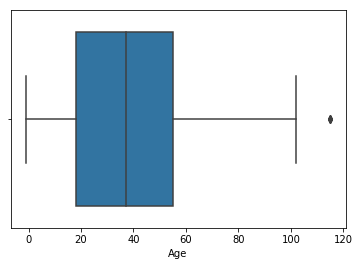

In [7]:
# create a boxplot of the age using seaborn
sns.boxplot(df.Age)
plt.show()

The boxplot confirms that there are outliers at the high end of the range. But the values below zero are not identified. To explore further these records can be brought up for examination.

In [8]:
# return all entries less than 0 years old.
df[df.Age < 0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5775010,4.659432e+14,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


Only one record was found, ruling out the possibility that this was a convention used for something like prenatal checkups. The entry appears to be an error.

In [9]:
# return all entries older than 100
df[df.Age > 100]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5651757,9.762948e+14,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
5700278,3.196321e+13,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5700279,3.196321e+13,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5562812,3.196321e+13,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5744037,3.196321e+13,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
5751563,2.342836e+11,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
5717451,7.482346e+14,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


These results are more interesting. There are two patients who were allegedly 115 years old. ["Super centurians"][1] are very rare, and I was unable to find any verifications that Brazil was home to two of them. It is extremeley unlikely that this information is accurate. Removing these entries along with the -1 patient will ensure that they don't cause any outlier affects.

There are also two patients reported to be 102. [According to wikipedia][2] there are several people in Brazil in this age range. It is very possible that these entries are accurate and can be left in.

The following cell will remove the records with outlier ages.

[1]: https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people
[2]: https://en.wikipedia.org/wiki/List_of_living_centenarians

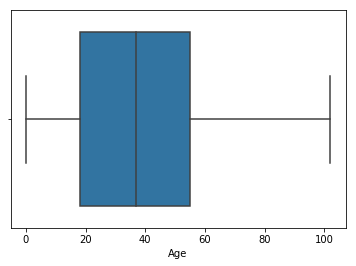

In [10]:
# Trim the outliers
df = df[(df.Age > -1) & (df.Age < 115)]

# display the boxplot again to verify the outcome
sns.boxplot(df.Age)
plt.show()

The outliers are no longer present in the boxplot.

To make the dataset easy to work with some of the fields need to be converted to new data types. SheduledDay and AppointmentDay fields should be datetime objects, and the No-Show field will be easier to work with as a binary value.

In [11]:
# Convert ScheduleDay and AppointmentDay to DateTime objects with pd.to_datetime
df.loc[:, ['ScheduledDay', 'AppointmentDay']] = df.loc[:, ['ScheduledDay', 'AppointmentDay']].apply(pd.to_datetime)

# drop the old No-show column
df.rename(columns={'No-show':'NoShow'}, inplace=True)

The day of week value can now be extracted from the AppointmentDay field to answer one of the research questions.

A function can be created to pull the weekday_name property from Pandas datetime objects and populate a new field.

In [12]:
# Create a function that takes a datetime (dt) and extracts the weekday_name property
day_from_datetime = lambda dt: dt.weekday_name

# Apply the function to the AppointmentDay column
df['DayOfWeek'] = df.AppointmentDay.apply(day_from_datetime)

Pandas makes it easy to review the outcome. The following command will count the number of appointments for each DayOfWeek value.

In [13]:
df.DayOfWeek.value_counts().to_frame(name='Number of Appointments')

,Number of Appointments
Wednesday,25867
Tuesday,25640
Monday,22712
Friday,19018
Thursday,17245
Saturday,39


Wednesday and Tuesday were the most common days for appointments, followed by Monday Friday and Thursday. Saturday was least common with only 39 appointments.

The last step of data cleaning will be to add a binary field for no shows. This will make calculating total and average  numbers of no shows easier in analysis.

In [14]:
# Pandas can cast True/False values to 1 and 0 respectively. That makes this step a breeze.
df['BinNoShow'] = (df.NoShow == "Yes").astype(int)

<a id='eda'></a>
## Exploratory Data Analysis

Before answering questions about the corrlations and dependencies in the data it is useful to understand

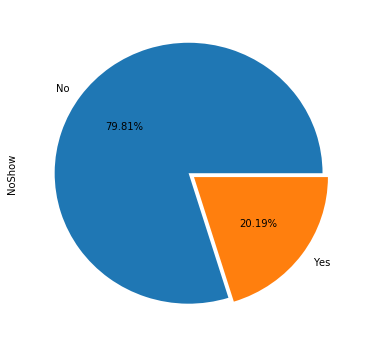

In [15]:
"""
Plot the proportion of NoShows as a piechart.
Extra parameters are passed to ensure the pie chart is a square,
format the decimal and pop out the second slice for effect.
"""
df.NoShow.value_counts().plot.pie(figsize=(6,6), autopct='%.2f%%', explode=(0, .05))
plt.show()

Just over 20% of all appointments resulted in no shows. The research questions will attempt to answer if the demographics of these populations are the same. They will also try to answer if this proportion is consistant given serveral priori.

> **Note**: Many of the variables to be tested in the research questions are categorical. This means that the chi-square test is appropriate for performing statistical testing. The chi-square test is used to determine how likely that an observed distribution is due to chance ([wikipedia][1]). This test requires multiple steps and is a good candidate to be packaged into a function.

[1]: https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test

In [16]:
def chi_test(colA, colB):
    """
    Performs a chi-quare test between the values of two columns
    :param colA: First column of test
    :param colB: Second column of test
    """
    
    # The first step is to create a contingecy table tabulated from the distribution of the values
    contingency_table = pd.crosstab(colA, colB)

    # Display the table
    display(contingency_table)

    # use scipy to calculate the chi test statistic, p_value and degrees of freedom    
    chi2, p_value, dof, _ = stats.chi2_contingency(contingency_table, False)

    # Output a summary of the results
    print('The chi-square test returned a value of {:.2f} and was performed with {} degree(s) of freedom.'.format(chi2, dof))
    print('The p-value was {:.3f}'.format(p_value))

### Research Question 1: Is there a difference the average age of patient who miss appointments and those who do not? 

A histogram allows visualization of the distribution of the patient ages. 

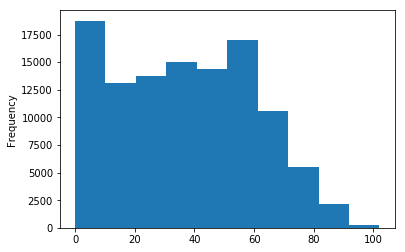

Mean age: 37.09


In [17]:
df.Age.plot.hist()
plt.show()
# print the mean age for extra information
print('Mean age: {:.2f}'.format(df.Age.mean()))

The age of the full dataset has a bimodal distribution, with peaks around 0 and 60 years old. There is also a positive skew, which is expected because the minimal age is floored at 0 while the maximum age naturally tapers off.

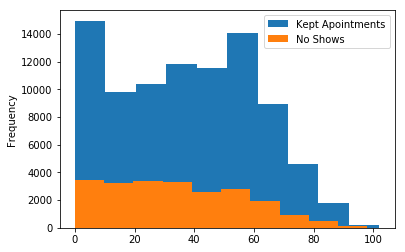

Kept Appointments Mean Age:37.79
Missed Appointments Mean Age:34.31


In [18]:
kept = (df.NoShow == 'No')
noshows = (df.NoShow == 'Yes')

df[kept].Age.plot.hist()
df[noshows].Age.plot.hist()
plt.legend(['Kept Apointments', 'No Shows'])
plt.show()
print('Kept Appointments Mean Age:{:.2f}'.format(df[kept].Age.mean()))
print('Missed Appointments Mean Age:{:.2f}'.format(df[noshows].Age.mean()))

This histogram overlays the distributions of kept appointments and no shows so that they can be compared. The peak near 60 years is much smaller for no shows. The mean is also lower but is not apparent with a histogram. Box plots provide a better visualization for interpreting the difference in means. 

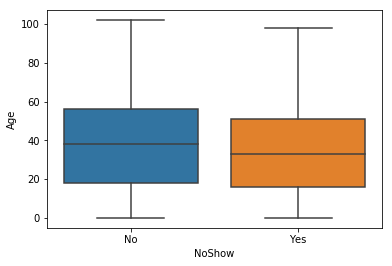

In [19]:
# display a box plot of the age distribution for each No Show condition
sns.boxplot(x=df.NoShow, y=df.Age)
plt.show()

The average age and quartiles are slightly lower for NoShows. A T-test can be used to determine if the difference of the means is significant.

In [20]:
# create filter for NoShows
noshows = (df.NoShow == "Yes")

# create pointers to the sample populations
noshow_ages = df[noshows].Age
show_ages = df[~noshows].Age

stat, p = stats.ttest_ind(noshow_ages, show_ages)
print(
    'The average age of noshows (M={:.2f}, SD={:.2f}) '.format(
        noshow_ages.mean(),
        noshow_ages.std())
    + 'was lower than kept appointments (M={:.2f}, SD={:.2f}) '.format(
        show_ages.mean(),
        show_ages.std())
    + 'by {:.2f} years.'.format(
        show_ages.mean() - noshow_ages.mean()
    )
)
print('The t-stastic was {:.2f} with a p-value of {:.3f}'.format(stat, p))

The average age of noshows (M=34.31, SD=21.95) was lower than kept appointments (M=37.79, SD=23.34) by 3.48 years.
The t-stastic was -20.15 with a p-value of 0.000


The results show that there was a small but statistically significant difference.

### Research Question 2: Are SMS notifications associated with lowered incidences of No Shows?

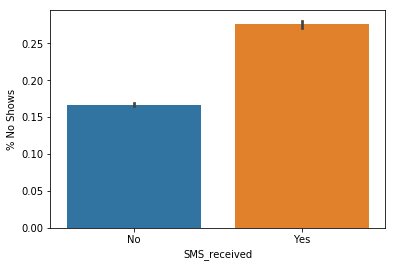

In [21]:
# this dictionary will be used to map 1s and 0s to Yeses and Nos
yesno = {1:'Yes', 0:'No'}

# bar plot the percentage of noshows for each sms condition
ax = sns.barplot(x=df.SMS_received.map(yesno), y=df.BinNoShow)
ax.set_ylabel('% No Shows')
plt.show()

Suprisingly, the percentage of no shows is much higher when SMS messages were received.

In [22]:
# test the statistical significance with a chi-square test
chi_test(df.NoShow, df.SMS_received.map(yesno))

SMS_received,No,Yes
NoShow,,
No,62508,25697
Yes,12532,9784


The chi-square test returned a value of 1767.97 and was performed with 1 degree(s) of freedom.
The p-value was 0.000


The chi-square test found the difference to be statistically significant.

### Research Question 3: Are there more No Shows on some days of the week?

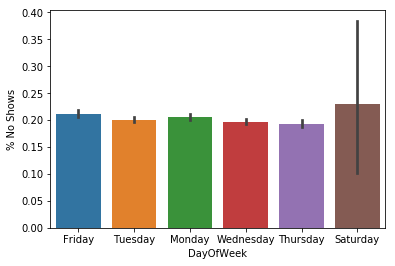

In [23]:
# Ploot the average no shows for each day of the week.
ax = sns.barplot(x=df.DayOfWeek, y=df.BinNoShow)
ax.set(ylabel='% No Shows')
plt.show()

There appear to be higher incidences of no shows on Saturdays and Fridays. The error bar is also highest for Saturdays due to the extremely low incidence of Saturday apointments.

In [24]:
chi_test(df.NoShow, df.DayOfWeek)

DayOfWeek,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
NoShow,,,,,,
No,14981,18023,30,13909,20488,20774
Yes,4037,4689,9,3336,5152,5093


The chi-square test returned a value of 27.64 and was performed with 5 degree(s) of freedom.
The p-value was 0.000


The chi-square test showed that the differences were statistically significant.

<a id='conclusions'></a>
## Conclusions

The analysis confirmed that several variables were correlated with No Shows. There was a small but statistically significant difference in average age between patients who missed their appointments and those who did not. In addition, certain days of the week were linked to higher occurances of no shows. However, the relationship between SMS_received and No Shows was contrary to what was expected. And as is always the case, it is important to remember that correlation does not imply causation.

One limitation of this analysis was the lack of background information. In the initial analysis of the data it was found that only 32% of the appointments had SMS messages received. It is possible that patients were more likely to be encouraged to enroll in SMS notifications after they have already missed an appointment. That would mean that those who were receiving SMSes were also more likely to have problems making appointments.

An area for further research could be look for trends in patients with multiple appointments and determine if SMSes are being used in this way. A repeated samples t-test could also be used to determine if they are effective in reducing No Show rates in patients who had SMSs activated after initial appointments and those who did not.

In [25]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0